In [ ]:
# install metrics dependencies
!pip install sacrebleu
!pip install evaluate
!pip install git+https://github.com/google-research/bleurt.git

## Results analysis

In [1]:
# metrics library
import evaluate

# Import statistics Library
# import statistics
import scipy.stats as stats

# plot libraries
import seaborn as sns
import matplotlib.pyplot as plt

# other libraries
import pandas as pd
import numpy as np
pd.options.display.max_colwidth = 200

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

# save path
save_path = 'results/'
key = 'data_v3'

# load data
test = pd.read_csv('results/test_predictions.csv')

c:\Users\andre\anaconda3\envs\linclusivo\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
## Tools for metrics computing
# Create metric objects
bleurtscore = evaluate.load("bleurt", module_type="metric")
sacrebleuscore = evaluate.load("sacrebleu")

# Evaluation function
def sacreb_bleurt_whmean_individuals(predictions, references, weight_sac=0.4, weight_bleurt=0.6):

  # compute bleurt score
  results_bleurt = bleurtscore.compute(predictions=predictions, references=references)

  # Bleurt score over 100
  res_bleurt = [results_bleurt['scores'][i] * 100 for i in range(len(results_bleurt['scores']))]

  # compute sacrebleu
  res_sac = []
  for i in range(len(predictions)):
    results_sac = sacrebleuscore.compute(predictions=[predictions[i]], references=[references[i]])
    res_sac.append(results_sac['score'])

  # Calculate harmonic mean

  metrics_score = np.asarray([res_sac, res_bleurt])
  metrics_score = np.where(metrics_score <= 0, 0.001, metrics_score)
  w_harm_mean = stats.hmean(metrics_score, axis=0, weights=[[weight_sac], [weight_bleurt]])

  # Set bleurt negative values to cero
  res_bleurt = [x if x > 0 else 0 for x in res_bleurt ]

  return {'sacrebleu': res_sac, 'bleurt':res_bleurt, 'w_hmean': w_harm_mean}

# Delete \n characters
test['predictions'] = test['predictions'].apply(lambda x: x.replace('\n', '').lstrip().rstrip())

# Compute metrics
evaluation = sacreb_bleurt_whmean_individuals(predictions=test['predictions'], references=test['gender_inclusive'])

# Create columns with metric results
test['sacrebleu'] = evaluation['sacrebleu']
test['bleurt'] = evaluation['bleurt']
test['w_hmean'] = evaluation['w_hmean']

# save evaluated predictions
test.to_csv(f'{save_path}evaluated_predictions_{key}.csv', index=False)

# set columns order
test = test[['gender_exclusive', 'predictions', 'gender_inclusive',
     'sacrebleu', 'bleurt', 'w_hmean', 'difficulty', 'origin']]

INFO:tensorflow:Reading checkpoint C:\Users\andre\.cache\huggingface\metrics\bleurt\default\downloads\extracted\83b60c723c19d51596302fa96e9f023903123f90b263a3e759cfa35e9b19a51c\bleurt-base-128.


INFO:tensorflow:Reading checkpoint C:\Users\andre\.cache\huggingface\metrics\bleurt\default\downloads\extracted\83b60c723c19d51596302fa96e9f023903123f90b263a3e759cfa35e9b19a51c\bleurt-base-128.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Will load checkpoint bert_custom


INFO:tensorflow:Will load checkpoint bert_custom


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:... name:bert_custom


INFO:tensorflow:... name:bert_custom


INFO:tensorflow:... vocab_file:vocab.txt


INFO:tensorflow:... vocab_file:vocab.txt


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... do_lower_case:True


INFO:tensorflow:... do_lower_case:True


INFO:tensorflow:... max_seq_length:128


INFO:tensorflow:... max_seq_length:128


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating WordPiece tokenizer.


INFO:tensorflow:Creating WordPiece tokenizer.


INFO:tensorflow:WordPiece tokenizer instantiated.


INFO:tensorflow:WordPiece tokenizer instantiated.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Loading model.


INFO:tensorflow:Loading model.


INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


Average sacrebleu score: 74.5
Average bleurt score: 68.5


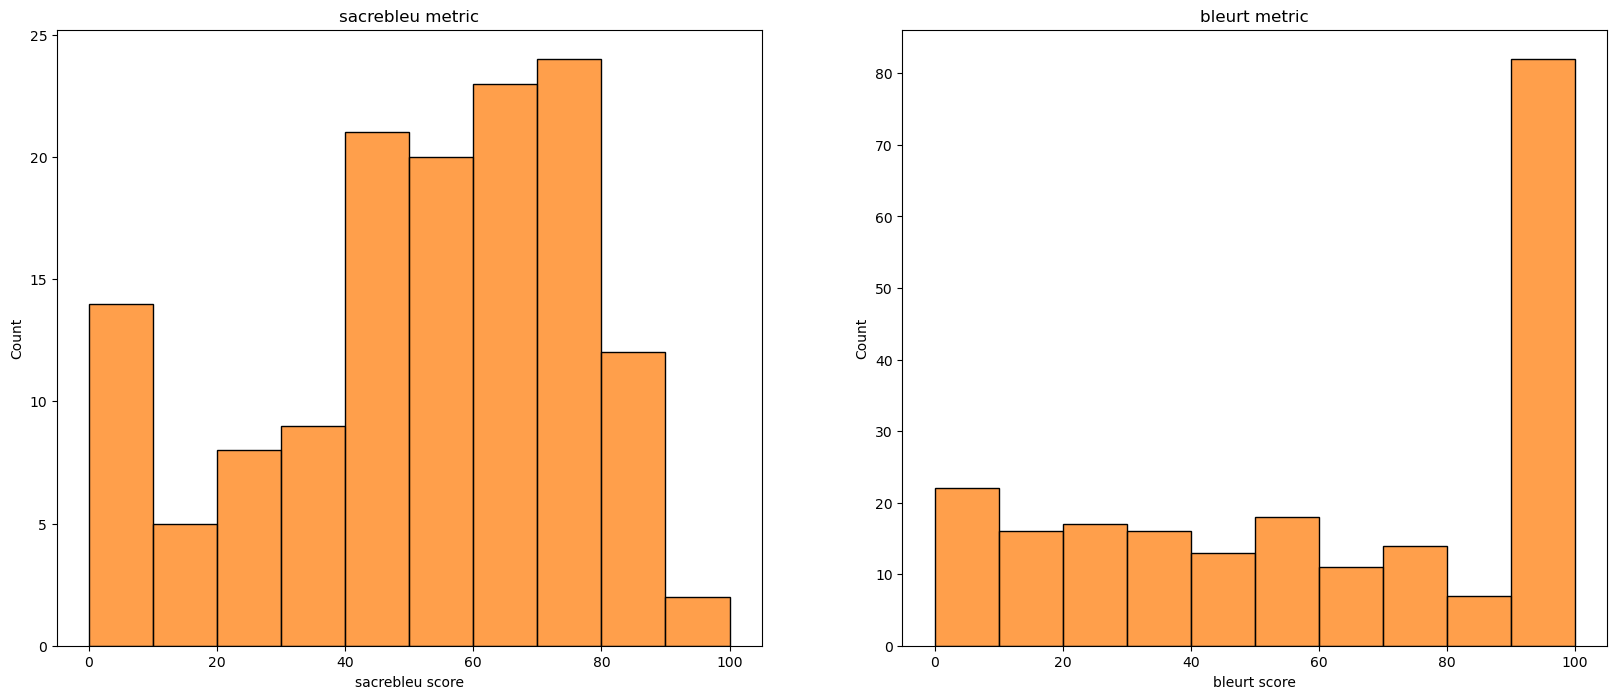

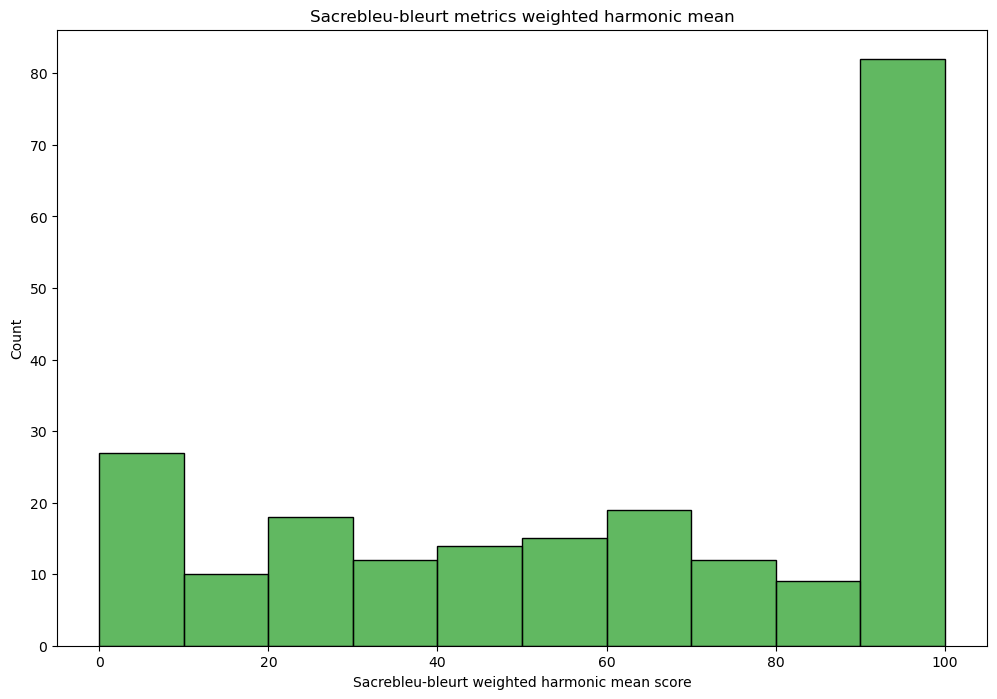

Average w_hmean score: 68.4


In [16]:
# Plot metric scores distribution
metrics = ['sacrebleu', 'bleurt', 'w_hmean']

# set bins
step=10
bins = np.arange(0, 100+step, step)

# subplots for two firts metrics
fig, axis = plt.subplots(1, 2, figsize=[20,8])
for i, metric in enumerate(metrics):
   
  if i == 2:
    plt.show()

    # figure for third metric
    fig, axis = plt.subplots(1,1,figsize=[12,8])

    # weighted harmonic mean score plot
    sns.histplot(test, x=metric, ax=axis, color='tab:green', bins=bins)
    axis.set_title(f'Sacrebleu-bleurt metrics weighted harmonic mean')
    axis.set_xlabel(f'Sacrebleu-bleurt weighted harmonic mean score')
    plt.show()
    
  else:
    # Sacrebleu and bleurt scores plots
    sns.histplot(test, x=metric, ax=axis[i], color='tab:orange', bins=bins)
    axis[i].set_title(f'{metric} metric')
    axis[i].set_xlabel(f'{metric} score')
  
  # print average scores
  avg_score = test[metric].mean()
  print(f'Average {metric} score: {avg_score:.1f}')
  


In [7]:
mask = test['sacrebleu'] == 0
test[mask]

,gender_exclusive,predictions,gender_inclusive,sacrebleu,bleurt,w_hmean,difficulty,origin
5,David es vendedor,David es vendedor,David es vendedor,0.0,99.489790,0.0025,feminizar_profesiones,human_combinatory
12,en la vida de los académicos,en la vida académica,su labor profesional,0.0,-37.886506,0.0010,otros,guia_IEM
27,Todos los relevadores,Relevadores,Las personas que desempeñan tareas de relevo,0.0,-36.085030,0.0010,colectivos,guia_TAI
52,labor profesional de estos,labor profesional de estas,su desempeño,0.0,-65.542722,0.0010,otros,guia_IEM
98,Los jóvenes que deseen estudiar,Quienes deseen estudiar,La juventud que desee estudiar,0.0,11.106829,0.0025,plural_neutro,guia_MX
105,Datos de la solicitante,Datos la solicitante,Datos la persona solicitante,0.0,64.150769,0.0025,dificultades_variadas,neutral_es
110,Participaron unos veintitrés participantes,Participaron veintitrés participantes,Participaron al rededor de veintitrés participantes,0.0,11.004883,0.0025,dificultades_variadas,neutral_es
118,Participaron unos quinientos asistentes,Participaron quinientos asistentes,Participaron al rededor de quinientos asistentes,0.0,25.654644,0.0025,dificultades_variadas,neutral_es
123,Participaron unos quinientos participantes,Participaron quinientos participantes,Participaron al rededor de quinientos participantes,0.0,23.342428,0.0025,dificultades_variadas,neutral_es
156,Los historiadores tradicionales,Los historiadores tradicionales,La historia tradicional,0.0,16.943671,0.0025,otros,guia_IEM


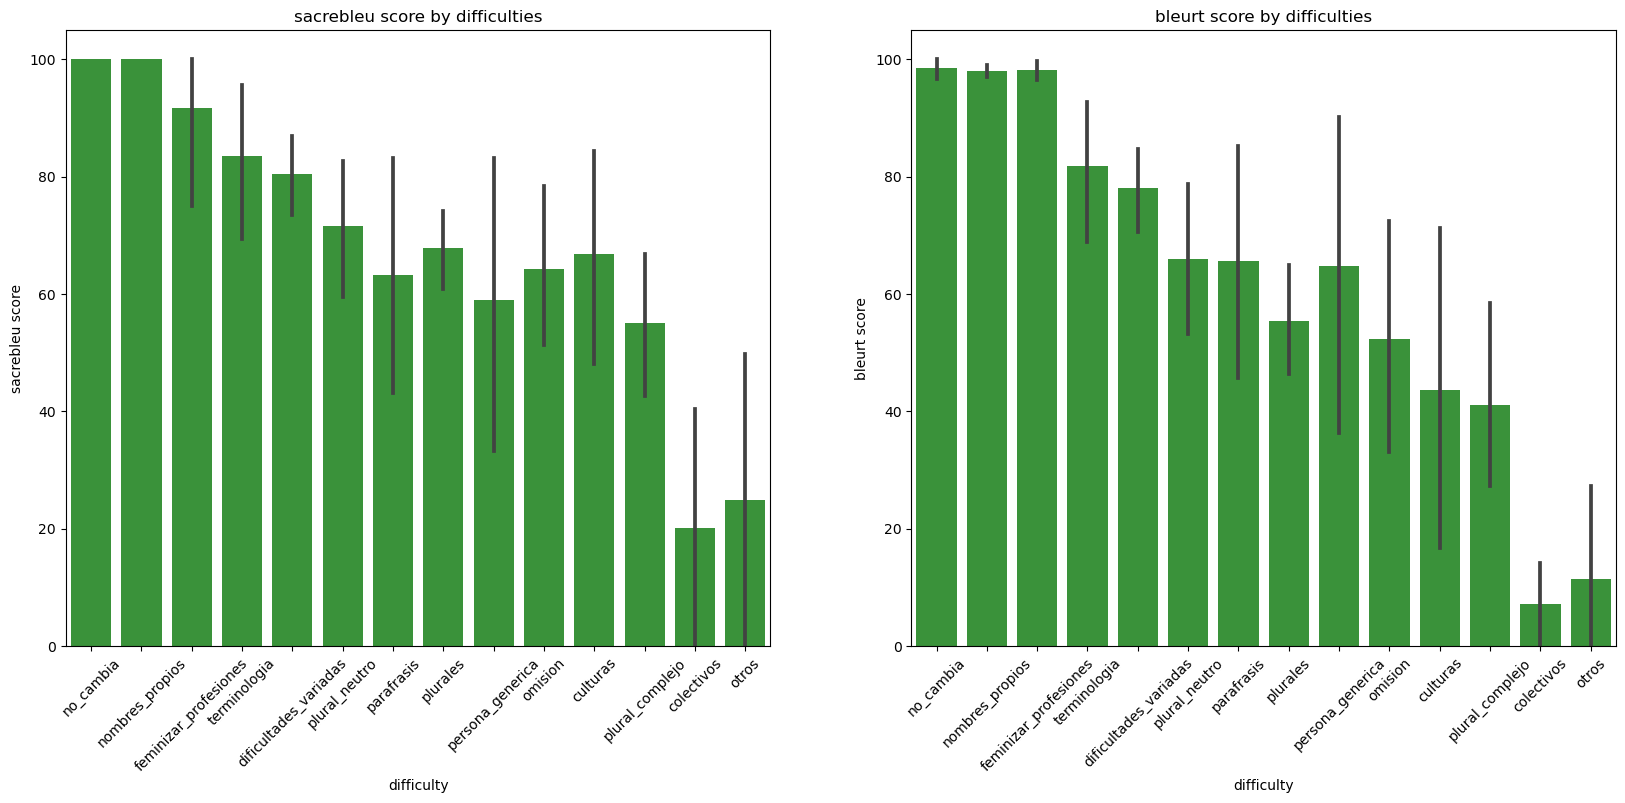

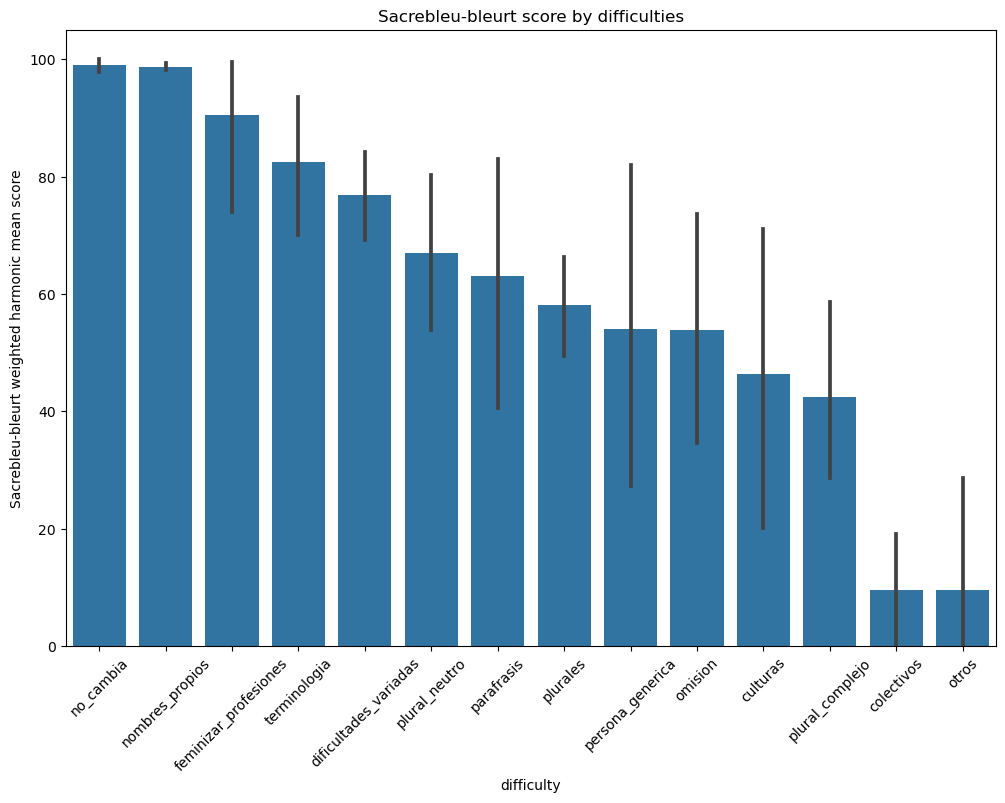

In [17]:
# Scores by difficulty
order = test.groupby(by='difficulty').mean(numeric_only=True).w_hmean.sort_values(ascending=False).index

fig, axis = plt.subplots(1, 2, figsize=[20,8])
for i, metric in enumerate(metrics):
    
  if i == 2:
    
    plt.show()
    fig, axis = plt.subplots(1,1,figsize=[12,8])
    sns.barplot(test, x='difficulty', y=metric, ax=axis, color='tab:blue', order=order)
    axis.set_title(f'Sacrebleu-bleurt score by difficulties')
    axis.set_xticklabels(axis.get_xticklabels(), rotation=45)
    axis.set_ylabel('Sacrebleu-bleurt weighted harmonic mean score')
    plt.show()
  else:
    sns.barplot(test, x='difficulty', y=metric, ax=axis[i], color='tab:green', order=order)
    axis[i].set_title(f'{metric} score by difficulties')
    axis[i].set_xticklabels(axis[i].get_xticklabels(), rotation=45)
    axis[i].set_ylabel(f'{metric} score')
    axis[i].set_ylim([0, 105]);

In [25]:
mask = test['difficulty'] == 'plural_complejo'
test[mask]

,gender_exclusive,gender_inclusive,difficulty,origin,predictions,sacrebleu,bleurt,w_hmean,input_words,pred_n_words,target_n_words,target_pred_nword_difference
11,Unos cincuenta voluntarios participaron en la limpieza del parque.,Aproximadamente cincuenta voluntarios participaron en la limpieza del parque.,parafrasis,GPT-3.5_fewshot,Aproximadamente cincuenta personas participaron en la limpieza del parque.,70.710678,75.902915,73.737128,9,9,9,0
25,El personal que no esté capacitado para esta tarea debe solicitar formación,El personal que no tenga capacitación para esta tarea debe solicitar formación,parafrasis,GPT-3.5_fewshot,El personal que no tenga la capacitación para esta tarea debe solicitar formación,76.116060,93.718666,85.783359,12,13,12,-1
50,Se alienta a los ciudadanos a reciclar para reducir la contaminación.,Se alienta a cada ciudadano a reciclar para reducir la contaminación.,parafrasis,GPT-3.5_fewshot,Se alienta a la ciudadanía a reciclar para reducir la contaminación.,63.404663,66.172010,65.036580,11,11,11,0
51,El personal que no esté contemplado en el contrato no podrá asistir;,El personal que no se contemple en el contrato no podrá asistir,parafrasis,GPT-3.5_fewshot,El personal que no esté contemplado en el contrato no podrá asistir;,57.835699,55.845720,56.625049,12,12,12,0
155,Deberán participar los docentes que hayan presentado la solicitud,Deberá participar cualquier docente que haya presentado la solicitud,parafrasis,GPT-3.5_fs_multiplication,Deberá participar cualquier docente que haya presentado la solicitud,100.000000,103.875732,102.289939,9,9,9,0
179,Llegarán a la final distintos albañiles del país,Llegarán a la final albañiles diferentes del país,parafrasis,GPT-3.5_fs_multiplication,Llegarán a la final albañiles diferentes del país,100.000000,101.864004,101.110125,8,8,8,0
180,Intervendrán distintos ponentes,Intervendrán diferentes ponentes,parafrasis,guía_CCGG,Intervendrán distintas personas especialistas,15.973578,0.000000,0.001667,3,4,3,-1
203,Deberán participar los detectives que se hayan comprometido,Deberá participar cualquier detective que se haya comprometido,parafrasis,GPT-3.5_fs_multiplication,Deberá haber detectives que se hayan comprometido,13.540372,37.033072,21.861259,8,7,8,1
204,"Según han estimado muchos expertos, la economía mundial enfrentará desafíos significativos en el próximo año.","Según han estimado multitud de especialistas, la economía mundial enfrentará desafíos significativos en el próximo año.",parafrasis,GPT-3.5_fewshot,"Según han estimado numerosos expertos, la economía mundial enfrentará desafíos significativos en el próximo año.",71.890858,56.071895,61.483457,15,15,16,1


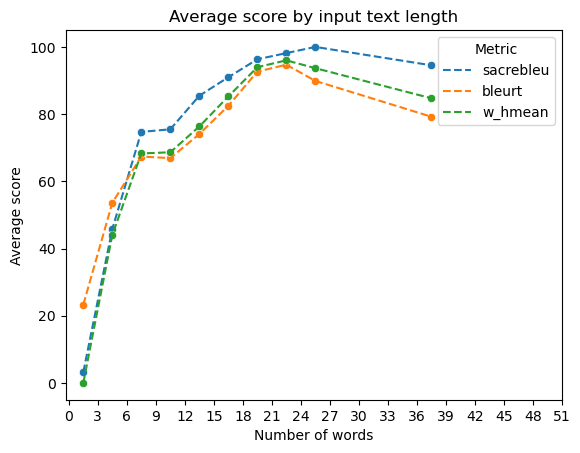

In [20]:
# Add word count columns
def word_count(string):
  return len(string.split())

test['input_words'] = test['gender_exclusive'].apply(word_count)

# Create bins to discretizate
step_size = 3
bin_edges = np.arange(0, 50 + step_size, step_size)
bin_centers = bin_edges[:-1] + step_size/2

for metric in metrics:
  ## Cut the bin values into discrete intervals. Returns a Series object.
  inwords_binned = pd.cut(test['input_words'], bin_edges, include_lowest=False)

  ## For the points in each bin, we compute the mean and standard error of the mean.
  score_mean = test[metric].groupby(inwords_binned).mean()
  score_std = test[metric].groupby(inwords_binned).std()

  ## Plot the summarized data
  # plt.errorbar(x=bin_centers, y=score_mean, yerr=score_std, linestyle='--')
  sns.scatterplot(x=bin_centers, y=score_mean)
  sns.lineplot(x=bin_centers, y=score_mean, linestyle='--', label=metric)
  plt.title(f'Average score by input text length')
  plt.xlabel('Number of words')
  plt.xticks(bin_edges)
  plt.ylabel(f'Average score')
  # metrics_legend = ['sacrebleu', 'bleurt', 'sacre-bleurt whmean']
  plt.legend(title='Metric');
  # plt.savefig(f'{save_path}score_by_length.png', bbox_inches='tight')

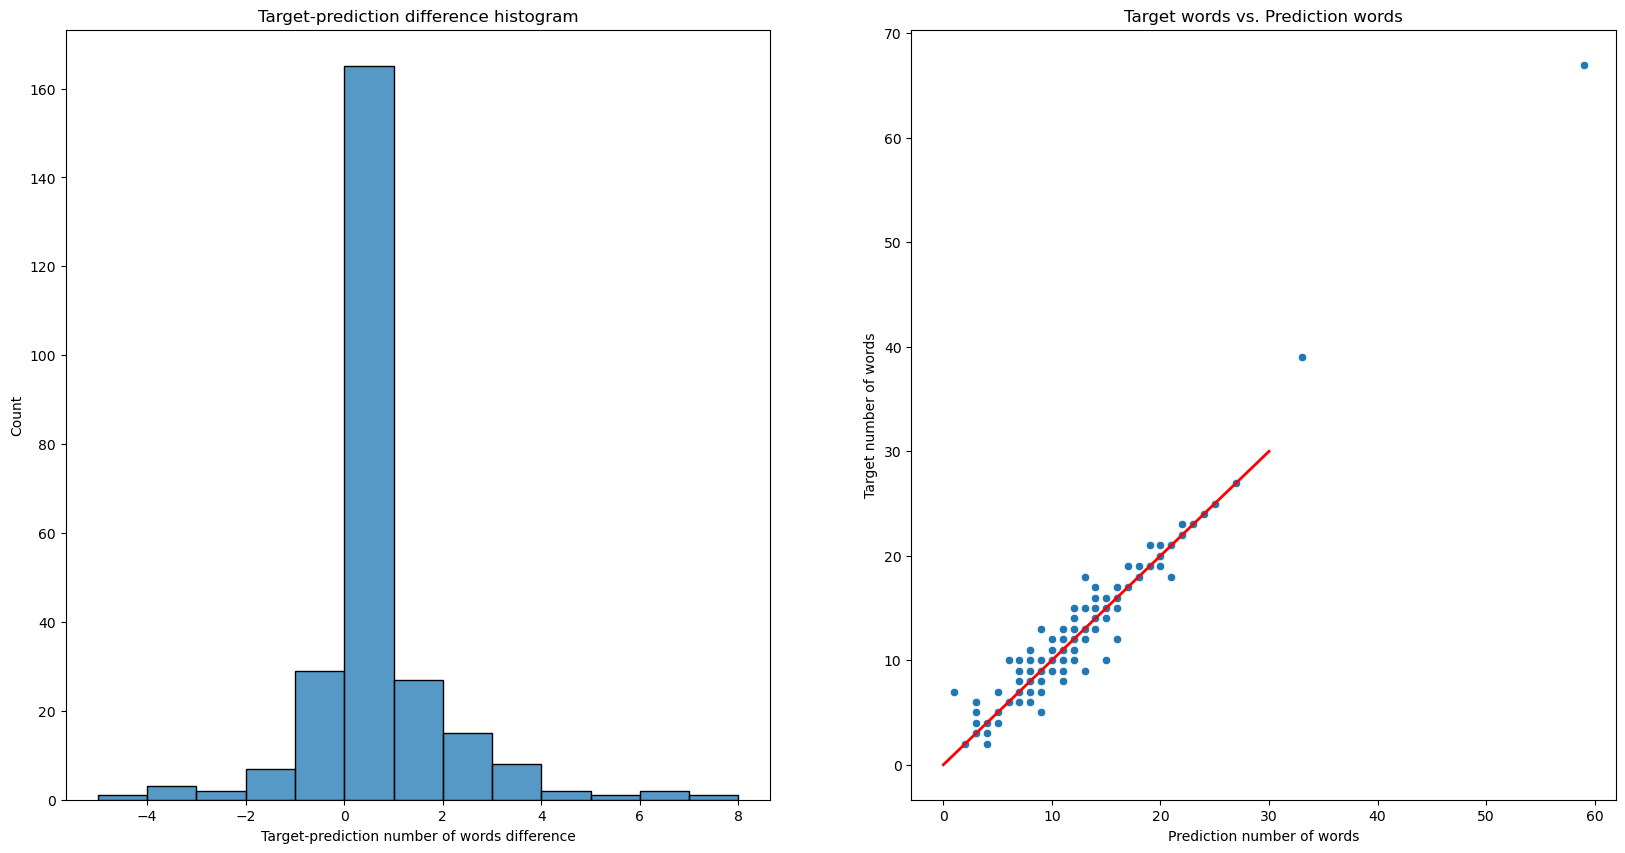

In [21]:
# Create columns with number of words information
test['pred_n_words'] = test['predictions'].apply(word_count)
test['target_n_words'] = test['gender_inclusive'].apply(word_count)
test['target_pred_nword_difference'] = test['target_n_words'] - test['pred_n_words']

# Create subplot
fig, axis = plt.subplots(1, 2, figsize=[20, 10])
# Plot target-prediction difference histogram
bins = np.arange(test.target_pred_nword_difference.min(), test.target_pred_nword_difference.max() + 1, 1)
sns.histplot(test, x='target_pred_nword_difference', bins=bins, ax=axis[0])
axis[0].set_xlabel('Target-prediction number of words difference')
axis[0].set_title('Target-prediction difference histogram')

# Plot prediction vs. target number of words
sns.scatterplot(test, x='pred_n_words', y='target_n_words', ax=axis[1])
# axis[1].plot([0,0], [30, 30], color='green', marker='o', linestyle='dashed',
#      linewidth=2, markersize=12)
axis[1].plot([0,60], [0, 60], color='red', linestyle='-', linewidth=2)
axis[1].set_xlabel('Prediction number of words')
axis[1].set_ylabel('Target number of words')
axis[1].set_title('Target words vs. Prediction words');

Texts that must not be translated:  41
Non traslated texts:  46
Correctly non translated texts: 40 
				(97.6% of total not to be translated examples)
				(87.0% of all non translated examples)
Incorrectly non translated texts: 6 
				(13.0% of all non traslated examples) 



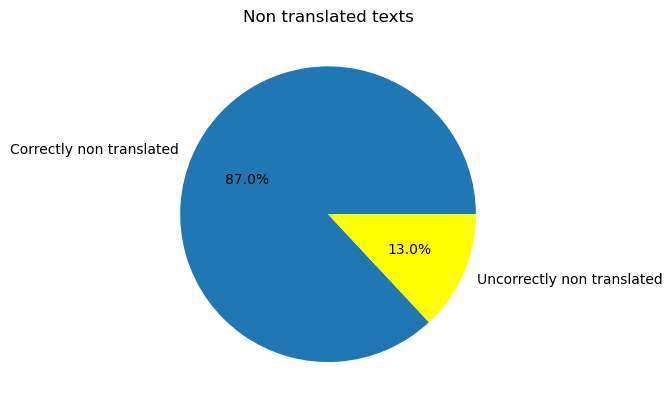

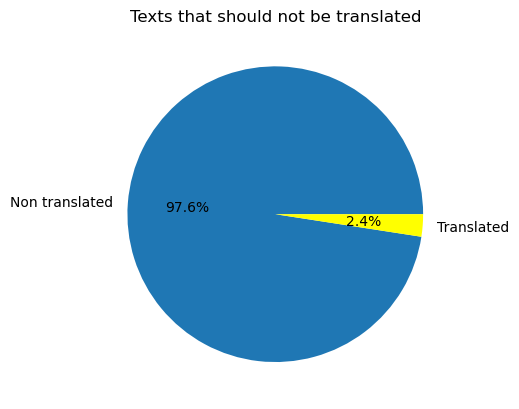

In [23]:
# Non translated texts
pred_eq_in = test['predictions'].apply(lambda x: x.lower()) == test['gender_exclusive'].apply(lambda x: x.lower())
in_eq_targ = test['gender_exclusive'].apply(lambda x: x.lower()) == test['gender_inclusive'].apply(lambda x: x.lower())
correct = pred_eq_in & in_eq_targ
uncorrect = pred_eq_in & (~in_eq_targ)


print('Texts that must not be translated: ', in_eq_targ.sum())
print('Non traslated texts: ', pred_eq_in.sum())
print(f'Correctly non translated texts: {correct.sum()} \n\t\t\t\t({100*correct.sum()/in_eq_targ.sum():.1f}% of total not to be translated examples)\n\t\t\t\t({100*correct.sum()/pred_eq_in.sum():.1f}% of all non translated examples)')
print(f'Incorrectly non translated texts: {uncorrect.sum()} \n\t\t\t\t({100*(pred_eq_in.sum() - correct.sum())/pred_eq_in.sum():.1f}% of all non traslated examples)', '\n')

# Pie chart for non translated data
labels = ['Correctly non translated', 'Uncorrectly non translated']
sizes = [correct.sum(), pred_eq_in.sum() - correct.sum()]
colors = ['tab:blue', 'yellow']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
plt.title('Non translated texts');
plt.show()

labels = ['Non translated', 'Translated']
sizes = [correct.sum(), in_eq_targ.sum() - correct.sum()]
colors = ['tab:blue', 'yellow']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
plt.title('Texts that should not be translated');
plt.show()